In [55]:
import time
# science
import numpy as np
import torch
from einops import repeat, rearrange

In [56]:
import joblib
import sidechainnet

In [57]:
from sidechainnet.utils.sequence import ProteinVocabulary as VOCAB
VOCAB = VOCAB()

### Load a protein in SCN format - you can skip this since a joblib file is provided

In [58]:
dataloaders = sidechainnet.load(casp_version=7, with_pytorch="dataloaders")
dataloaders.keys() # ['train', 'train_eval', 'valid-10', ..., 'valid-90', 'test']
# ProteinDataset(casp_version=12, split='train', n_proteins=81454,
#               created='Sep 20, 2020')

SidechainNet was loaded from ./sidechainnet_data/sidechainnet_casp7_30.pkl.


dict_keys(['train', 'train-eval', 'test', 'valid-10', 'valid-20', 'valid-30', 'valid-40', 'valid-50', 'valid-70', 'valid-90'])

In [59]:
min_len = 700
for batch in dataloaders['train']:
    real_seqs = [''.join([VOCAB.int2char(aa) for aa in seq]) for seq in batch.int_seqs.numpy()]
    print("seq len", len(real_seqs[0]))
    try:
        for i in range(len(batch.int_seqs.numpy())):
            # get variables
            seq     = real_seqs[i]
            int_seq = batch.int_seqs[i]
            angles  = batch.angs[i]
            # get padding
            padding_angles = (torch.abs(angles).sum(dim=-1) == 0).long().sum()
            padding_seq    = (np.array([x for x in seq]) == "_").sum()
            # only accept sequences with right dimensions and no missing coords
            # if padding_seq == padding_angles:
            # print("paddings_match")
            # print("len coords", list(batch.crds[i].shape)[0]//3, "vs int_seq", len(int_seq))
            if list(batch.crds[i].shape)[0]//14 == len(int_seq):
                if len(seq) > min_len and padding_seq == padding_angles:
                    print("stopping at sequence of length", len(seq))
                    print(len(seq), angles.shape, padding_seq == padding_angles == list(batch.crds[i].shape)[0]//3)
                    print("paddings: ", padding_seq, padding_angles)
                    raise StopIteration
                else:
                    print("found a seq of length:", len(seq), "but below the threshold:", min_len)
    except StopIteration:
        break

seq len 174
found a seq of length: 174 but below the threshold: 700
found a seq of length: 174 but below the threshold: 700
found a seq of length: 174 but below the threshold: 700
found a seq of length: 174 but below the threshold: 700
found a seq of length: 174 but below the threshold: 700
found a seq of length: 174 but below the threshold: 700
found a seq of length: 174 but below the threshold: 700
found a seq of length: 174 but below the threshold: 700
found a seq of length: 174 but below the threshold: 700
found a seq of length: 174 but below the threshold: 700
found a seq of length: 174 but below the threshold: 700
found a seq of length: 174 but below the threshold: 700
found a seq of length: 174 but below the threshold: 700
found a seq of length: 174 but below the threshold: 700
found a seq of length: 174 but below the threshold: 700
found a seq of length: 174 but below the threshold: 700
found a seq of length: 174 but below the threshold: 700
found a seq of length: 174 but below

found a seq of length: 128 but below the threshold: 700
found a seq of length: 128 but below the threshold: 700
found a seq of length: 128 but below the threshold: 700
found a seq of length: 128 but below the threshold: 700
found a seq of length: 128 but below the threshold: 700
found a seq of length: 128 but below the threshold: 700
found a seq of length: 128 but below the threshold: 700
found a seq of length: 128 but below the threshold: 700
found a seq of length: 128 but below the threshold: 700
found a seq of length: 128 but below the threshold: 700
found a seq of length: 128 but below the threshold: 700
found a seq of length: 128 but below the threshold: 700
found a seq of length: 128 but below the threshold: 700
found a seq of length: 128 but below the threshold: 700
found a seq of length: 128 but below the threshold: 700
found a seq of length: 128 but below the threshold: 700
found a seq of length: 128 but below the threshold: 700
found a seq of length: 128 but below the thresho

found a seq of length: 50 but below the threshold: 700
found a seq of length: 50 but below the threshold: 700
found a seq of length: 50 but below the threshold: 700
found a seq of length: 50 but below the threshold: 700
found a seq of length: 50 but below the threshold: 700
found a seq of length: 50 but below the threshold: 700
found a seq of length: 50 but below the threshold: 700
found a seq of length: 50 but below the threshold: 700
found a seq of length: 50 but below the threshold: 700
found a seq of length: 50 but below the threshold: 700
found a seq of length: 50 but below the threshold: 700
found a seq of length: 50 but below the threshold: 700
found a seq of length: 50 but below the threshold: 700
found a seq of length: 50 but below the threshold: 700
found a seq of length: 50 but below the threshold: 700
found a seq of length: 50 but below the threshold: 700
found a seq of length: 50 but below the threshold: 700
found a seq of length: 50 but below the threshold: 700
found a se

### Load joblib file

In [61]:
# joblib.dump({"seq": seq, "int_seq": int_seq, "angles": angles,
#              "id": batch.pids[i], "true_coords": batch.crds[i]}, "experiments/727_aas_seq_and_angles.joblib")
info = joblib.load("experiments/112_aas_seq_and_angles.joblib")
seq, int_seq, angles, id_, true_coords = info["seq"], info["int_seq"], info["angles"], info["id"], info["true_coords"]

padding_angles = (torch.abs(angles).sum(dim=-1) == 0).long().sum()
padding_seq    = (np.array([x for x in seq]) == "_").sum()

### Load algo

In [62]:
from massive_pnerf import *

In [63]:
# measure time to featurize
# %timeit build_scaffolds(seq[:-padding_seq], angles[:-padding_seq])

In [64]:
# featurize
scaffolds = build_scaffolds_from_scn_angles(seq[:-padding_seq], angles[:-padding_seq])

In [65]:
scaffolds["bond_mask"].shape

torch.Size([107, 14])

In [71]:
# %%timeit
# convert coords - fold
coords, mask = proto_fold(seq[:-padding_seq], **scaffolds)
coords_flat  = rearrange(coords, 'l c d -> (l c) d') 

9.97 ms ± 138 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [67]:
coords.shape

torch.Size([107, 14, 3])

#### Profiling

In [68]:
%load_ext snakeviz
%snakeviz proto_fold(seq[:-padding_seq], **scaffolds)

The snakeviz extension is already loaded. To reload it, use:
  %reload_ext snakeviz
 
*** Profile stats marshalled to file '/var/folders/lh/zgndpx8x755_lcsq48lp_5t40000gn/T/tmp3ff38ocg'. 
Embedding SnakeViz in this document...


#### Display

In [72]:
id_, true_coords.shape, len(int_seq[:-padding_angles-1]), seq

('2F2H_d2f2hf1',
 torch.Size([1568, 3]),
 106,
 'NTLLALGNNDQRPDYVWHEGTAFHLFNLQDGHEAVCEVPAADGSVIFTLKAARTGNTITVTGAGEAKNWTLCLRNVVKVNGLQDGSQAESEQGLVVKPQGNALTITL_____')

In [73]:
sb = sidechainnet.StructureBuilder(int_seq, crd=coords_flat) 
sb.to_3Dmol()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [74]:
sb = sidechainnet.StructureBuilder(int_seq[:-padding_angles], crd=true_coords[:-14*padding_angles]) # coords_flat
sb.to_3Dmol()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

### Diagnose rotation matrix

In [75]:
# Standard import
import matplotlib.pyplot as plt
# Import 3D Axes 
from mpl_toolkits.mplot3d import axes3d

In [76]:
%matplotlib notebook

#### True backbone

<IPython.core.display.Javascript object>


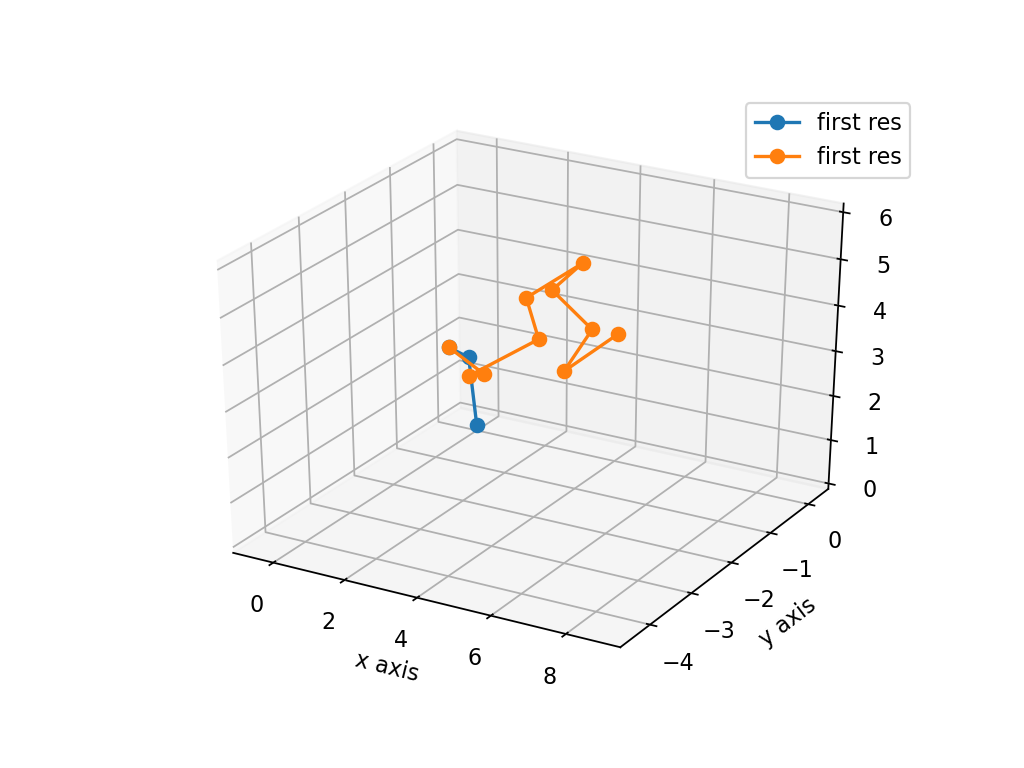

In [77]:
# print init of true chain to compare
# Set up Figure and 3D Axes 
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
start_res = (torch.cat([true_coords[:3, :],
                        true_coords[14:14+3],
                        true_coords[28:28+3],
                        true_coords[42:42+3]], dim=0) - true_coords[0, :]).numpy()

ax.plot(start_res[:3, 0], start_res[:3, 1], start_res[:3, 2],  "-o", label="first res")
ax.plot(start_res[2:, 0], start_res[2:, 1], start_res[2:, 2],  "-o", label="first res")
# ax.plot(first_res[:, 0], first_res[:, 1], first_res[:, 2],  "r-o", label="second aa")
# ax.plot(destin_first[:, 0], destin_first[:, 1], destin_first[:, 2],  "g-o", label="rotated second aa")
plt.legend()
plt.xlabel("x axis")
plt.ylabel("y axis")
plt.show()

### True and predicted backbone

<IPython.core.display.Javascript object>


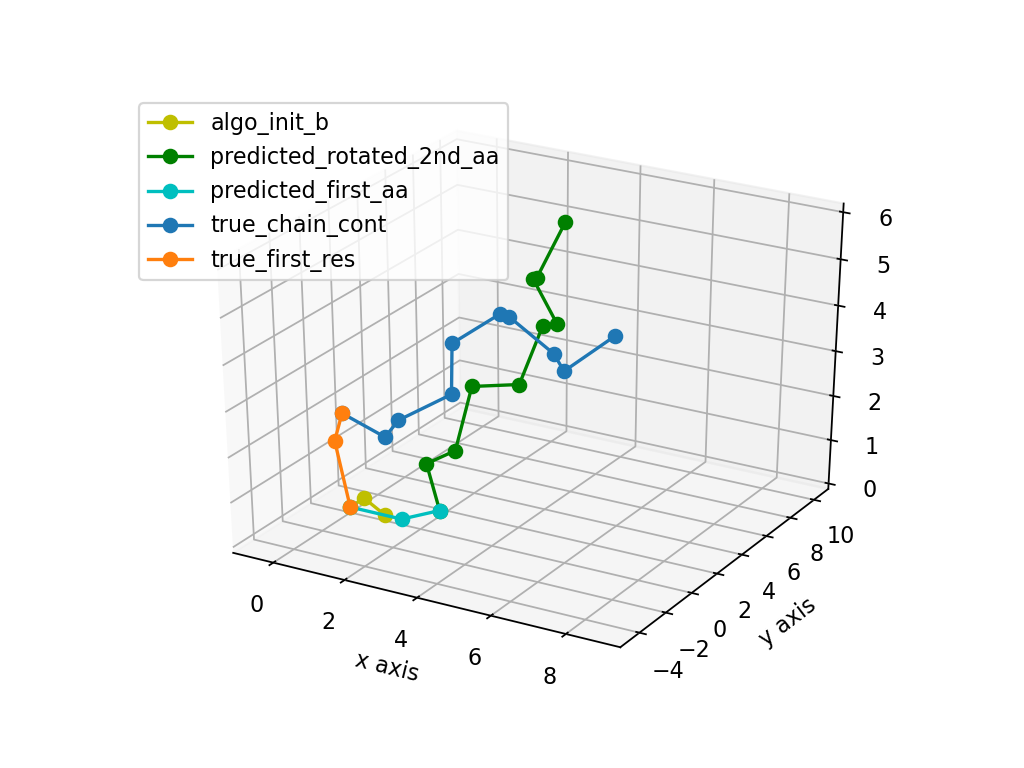

In [78]:
# Set up Figure and 3D Axes 
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
# Plot using Axes notation and standard function calls
prev_res = coords[0, :3].numpy()
destin_first = rearrange(coords[:4, :3], 'l c d -> (l c) d').numpy()


ax.plot([1,0,0],[0,1,0],[0,0,0], 'y-o', label="algo_init_b")
ax.plot(destin_first[2:, 0], destin_first[2:, 1], destin_first[2:, 2],  "g-o", label="predicted_rotated_2nd_aa")
ax.plot(prev_res[:, 0], prev_res[:, 1], prev_res[:, 2],  "c-o", label="predicted_first_aa")

ax.plot(start_res[2:, 0], start_res[2:, 1], start_res[2:, 2],  "-o", label="true_chain_cont")
ax.plot(start_res[:3, 0], start_res[:3, 1], start_res[:3, 2],  "-o", label="true_first_res")
# ax.plot(first_res[:, 0], first_res[:, 1], first_res[:, 2],  "r-o", label="second aa")

plt.legend()
plt.xlabel("x axis")
plt.ylabel("y axis")
plt.show()

### Rotate and show superimposed to confirm

In [79]:
def kabsch_torch(X, Y):
    """ Kabsch alignment of X into Y. 
        Assumes X,Y are both (Dims x N_points). See below for wrapper.
    """
    #  center X and Y to the origin
    X_ = X - X.mean(dim=-1, keepdim=True)
    Y_ = Y - Y.mean(dim=-1, keepdim=True)
    # calculate convariance matrix (for each prot in the batch)
    C = torch.matmul(X_, Y_.t())
    # Optimal rotation matrix via SVD - warning! W must be transposed
    V, S, W = torch.svd(C.detach())
    # determinant sign for direction correction
    d = (torch.det(V) * torch.det(W)) < 0.0
    if d:
        S[-1]    = S[-1] * (-1)
        V[:, -1] = V[:, -1] * (-1)
    # Create Rotation matrix U
    U = torch.matmul(V, W.t())
    # calculate rotations
    X_ = torch.matmul(X_.t(), U).t()
    # return centered and aligned
    return X_, Y_


In [80]:
flat_mask = rearrange(scaffolds["cloud_mask"], 'l d -> (l d)')
coords_aligned, labels_aligned = kabsch_torch(coords_flat[flat_mask].t(),
                                              true_coords[:-14*padding_angles][flat_mask].t())
# create coord scaffolds
scaff_coords_aligned = torch.zeros(coords_flat.shape).float()
scaff_labels_aligned = torch.zeros(coords_flat.shape).float()
# fill
scaff_coords_aligned[flat_mask] = coords_aligned.t()
scaff_labels_aligned[flat_mask] = labels_aligned.t()
# replace vars
coords_aligned, labels_aligned = scaff_coords_aligned, scaff_labels_aligned

<IPython.core.display.Javascript object>


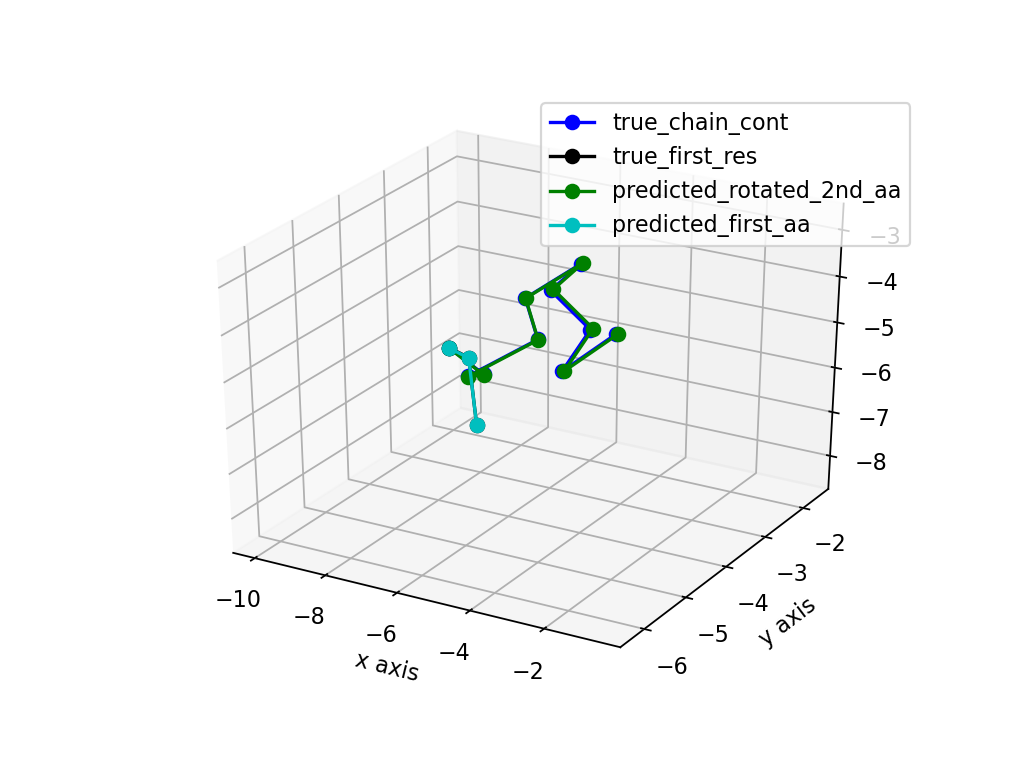

In [81]:
# Set up Figure and 3D Axes 
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
# Plot using Axes notation and standard function calls
start_res    = torch.cat([labels_aligned[:3, :],
                        labels_aligned[14:14+3],
                        labels_aligned[28:28+3],
                        labels_aligned[42:42+3]], dim=0).numpy()
destin_first = torch.cat([coords_aligned[:3, :],
                        coords_aligned[14:14+3],
                        coords_aligned[28:28+3],
                        coords_aligned[42:42+3]], dim=0).numpy()

destin_first -= (destin_first[:1] - start_res[:1])

ax.plot(start_res[2:, 0], start_res[2:, 1], start_res[2:, 2],  "b-o", label="true_chain_cont")
ax.plot(start_res[:3, 0], start_res[:3, 1], start_res[:3, 2],  "k-o", label="true_first_res")
# ax.plot(first_res[:, 0], first_res[:, 1], first_res[:, 2],  "r-o", label="second aa")

ax.plot(destin_first[2:, 0], destin_first[2:, 1], destin_first[2:, 2],  "g-o", label="predicted_rotated_2nd_aa")
ax.plot(destin_first[:3, 0], destin_first[:3, 1], destin_first[:3, 2],  "c-o", label="predicted_first_aa")

plt.legend()
plt.xlabel("x axis")
plt.ylabel("y axis")
plt.show()

In [82]:
boxel_pred_coords = rearrange(coords_aligned, '(l c) d -> l c d', c=14).numpy()
boxel_true_coords = rearrange(labels_aligned, '(l c) d -> l c d', c=14).numpy()

In [83]:
for i in range(15):
    print(i, "( n-ca, ca-c, c-n, c-o)", np.linalg.norm(boxel_pred_coords[i, :4] - \
                                                  np.concatenate([boxel_pred_coords[i, 1:3], # CA , C
                                                                  boxel_pred_coords[i+1, :1], # N+1
                                                                  boxel_pred_coords[i, 2:3]], # C
                                                                  axis=0), axis=-1),
                                   np.linalg.norm(boxel_true_coords[i, :4] - \
                                                  np.concatenate([boxel_true_coords[i, 1:3],
                                                                  boxel_true_coords[i+1, :1],
                                                                  boxel_pred_coords[i, 2:3]], axis=0), axis=-1))

0 ( n-ca, ca-c, c-n, c-o) [1.4664935 1.5241189 1.3289374 1.2290006] [1.4729016 1.5119934 1.330413  1.173232 ]
1 ( n-ca, ca-c, c-n, c-o) [1.4664931 1.5241189 1.328937  1.2290008] [1.4648343 1.5186538 1.3174567 1.2828858]
2 ( n-ca, ca-c, c-n, c-o) [1.466493  1.5241194 1.3289372 1.229    ] [1.4272082 1.5563269 1.3316144 1.2065895]
3 ( n-ca, ca-c, c-n, c-o) [1.4664935 1.524119  1.3289376 1.2290001] [1.4446503 1.5176473 1.3326255 1.2020067]
4 ( n-ca, ca-c, c-n, c-o) [1.4664935 1.5241188 1.3289368 1.2289991] [1.456298  1.522775  1.3344283 1.2852328]
5 ( n-ca, ca-c, c-n, c-o) [1.4664931 1.524119  1.3289387 1.2289996] [1.4675089 1.5232855 1.3250848 1.1780654]
6 ( n-ca, ca-c, c-n, c-o) [1.4664931 1.524119  1.3289376 1.2289995] [1.4661055 1.5011121 1.335454  1.2689474]
7 ( n-ca, ca-c, c-n, c-o) [1.4664919 1.5241213 1.3289378 1.2290008] [1.481046  1.5653684 1.3391701 1.2214217]
8 ( n-ca, ca-c, c-n, c-o) [1.4664927 1.5241188 1.3289373 1.2289997] [1.4622474 1.5181217 1.3367028 1.2807989]
9 ( n-ca, 

In [84]:
backbones = []
for i in range(len(boxel_true_coords)-1):
    backbones.append(np.linalg.norm(boxel_true_coords[i, :4] - \
                                    np.concatenate([boxel_true_coords[i, 1:3],
                                                    boxel_true_coords[i+1, :1],
                                                    boxel_pred_coords[i, 2:3]], axis=0), axis=-1))
    
# for (=O) it's a normal distro so picking the mean although high variabiity
print("mean:", np.vstack(backbones).mean(axis=0))
print("median:", np.median(np.vstack(backbones), axis=0))
print("std:", np.vstack(backbones).std(axis=0))

mean: [1.4562691 1.5263689 1.3298723 1.2307231]
median: [1.4569814 1.523855  1.3296897 1.2299892]
std: [0.01438655 0.01655221 0.00736604 0.06296895]


### Check error

In [85]:
def rmsd_torch(X, Y):
    """ Assumes x,y are both (B x D x N). See below for wrapper. """
    return torch.sqrt( torch.mean((X - Y)**2, axis=(-1, -2)) )

print("RMSD is:", rmsd_torch(coords_aligned, labels_aligned))

RMSD is: tensor(0.3349)


### Save oriented to manually diagnose

In [54]:
# save predicted
sb = sidechainnet.StructureBuilder(int_seq, crd=coords_aligned) 
sb.to_pdb("preds/predicted_112.pdb")
sb = sidechainnet.StructureBuilder(int_seq, crd=labels_aligned) 
sb.to_pdb("preds/labels_112.pdb")
# go here: https://molstar.org/viewer/
# load chains and use superimposition tool

In [27]:
# sb = sidechainnet.StructureBuilder(int_seq, crd=coords_flat) 
# sb.to_pdb("preds/predicted_112.pdb")